In [1]:
from pyspark import SparkConf, SparkContext
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import pandas as pd
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("/opt"))
import utils # for getting Spark Master URI

In [2]:
utils.set_ec2_identities() # retrieve metadata of current EC2 instance

True

In [3]:
os.environ['PYSPARK_PYTHON'] = 'python3'

In [4]:
conf = (SparkConf()
         .setMaster(utils.generate_master_uri()) # create SparkContext with Spark Master's URI of current running cluster
         .setAppName("My app")
         .set("spark.executor.memory", "2g"))
sc = SparkContext(conf = conf)

In [5]:
# Build a classification task using 3 informative features
X, y = make_classification(n_samples=12000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# or read from a file (for instance)
#df = pd.read_csv('data.csv', sep=' ', header=None)
#X = df[[1,2,3,4,5,6,7,8,9,10]].as_matrix()
#y = df[[0]][0].tolist()

# Partition data
def dataPart(X, y, start, stop): return dict(X=X[start:stop, :], y=y[start:stop])

def train(data):
    X = data['X']
    y = data['y']
    return ExtraTreesClassifier(n_estimators=100,random_state=0).fit(X,y)

# Merge 2 Models
from sklearn.base import copy
def merge(left,right):
    new = copy.deepcopy(left)
    new.estimators_ += right.estimators_
    new.n_estimators = len(new.estimators_)  
    return new

data = [dataPart(X, y, 0, 4000), dataPart(X,y,4000,8000), dataPart(X,y,8000,12000)]

In [6]:
forest = sc.parallelize(data).map(train).reduce(merge)

In [7]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [8]:
# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.316693)
2. feature 2 (0.257167)
3. feature 0 (0.189512)
4. feature 8 (0.034128)
5. feature 5 (0.033914)
6. feature 3 (0.033906)
7. feature 7 (0.033751)
8. feature 6 (0.033718)
9. feature 9 (0.033677)
10. feature 4 (0.033535)


In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

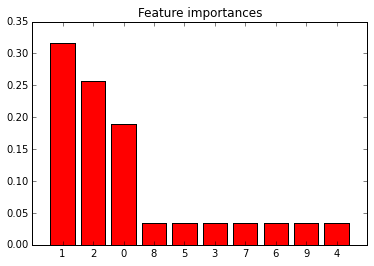

In [10]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices],
        color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()